# ***Set Parameters to define model etc***

In [ ]:
#### Undersampling Strategy:#####
Undersampling = "Regular" # Options: Regular or Possoin
Sampling_Mask = "One_Mask" #Options: Single_Combination or One_Mask or Complementary_Masks
AF = 2 #  acceleration factor

#### Model Input and Output ####
GT_Data = "LowRank" # Options: FullRank LowRank for GROUNDTRUTH!
Low_Rank_Input = True ## apply low rank to the input as well if True
trancuate_t = 96 # set this parameter to control at which time step you stop using the signal

####M Model Parameters ####
batch_size=64
Layers = 10

Test_Set = 0 # always trained with 0 test set !!

In [2]:
import os
import sys

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '0' #, this way I would choose GPU 3 to do the work

import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
#from Naive_CNN_3D_Residual import *
from output_statistics import *

from interlacer_layer_modified import *
from Residual_Interlacer_modified import *
from skimage.metrics import structural_similarity as ssim 

masks = np.load('../data/masks.npy')
grouped_time_steps = 1 # Set how many subsequent time steps you want to give to the network at once. Values allowed: 1, 2, 4, 8 (because it has to divide 8)

In [3]:
#### Define ground truth path####
if GT_Data == "FullRank":
    ground_truth_path = "../data/Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy"
elif GT_Data == "LowRank":
    ground_truth_path = "../data/Ground_Truth/Low_Rank/LR_8_P03-P08_self.npy"

#### Define Input Data path
undersampled_data_path = "../data/Undersampled_Data/"+Undersampling+f'/AF_{AF}/'+Sampling_Mask+'/data.npy'

#### Definie Model path
if GT_Data == "FullRank":
    saved_model_path = f"../saved_models/Interlacer/Full2Full/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/{Layers}Layer/best_model.pth'
elif GT_Data == "LowRank":
    saved_model_path = f"../saved_models/Interlacer/Low2Low/"+Undersampling+f'/AF_{AF}/'+f'Truncate_t_{trancuate_t}/'+Sampling_Mask+f'/{Layers}Layer/best_model.pth'
    
    
#### load data!
Ground_Truth = np.load(ground_truth_path)
Undersampled_Data = np.load(undersampled_data_path)
MASKS = np.load("../data/masks.npy")

####
mask_expanded = MASKS[:, :, :, None, None, :]  # Now shape is (22,22,21,1,1,6)
# Use broadcasting to "repeat" the mask along these new axes:
mask_extended = np.broadcast_to(mask_expanded, (22, 22, 21, 96, 8, 6))
mask_extended = mask_extended + 1J*mask_extended

#### additionally make LowRank 8 transformation on input of network, this improves the error significantly!
if Low_Rank_Input:
    Undersampled_Data[...,0] = low_rank(Undersampled_Data[...,0], 8)
    Undersampled_Data[...,1] = low_rank(Undersampled_Data[...,1], 8)
    Undersampled_Data[...,2] = low_rank(Undersampled_Data[...,2], 8)
    Undersampled_Data[...,3] = low_rank(Undersampled_Data[...,3], 8)
    Undersampled_Data[...,4] = low_rank(Undersampled_Data[...,4], 8)
    Undersampled_Data[...,5] = low_rank(Undersampled_Data[...,5], 8)

In [4]:
ground_truth_train, ground_truth_test = Ground_Truth[:,:,:,:trancuate_t,:,1:6], Ground_Truth[:,:,:,:trancuate_t,:,Test_Set]  # Method: Leave first MRSI measurement as test set
Train_Mask, Test_Mask = mask_extended[:,:,:,:trancuate_t,:,1:6], mask_extended[:,:,:,:trancuate_t,:,Test_Set]

#### Assign undersampled network input ####
NN_input_train, NN_input_test = Undersampled_Data[:,:,:,:trancuate_t,:,1:6], Undersampled_Data[:,:,:,:trancuate_t,:,Test_Set]

#### Fourier transform ####
training_undersampled, test_undersampled = fourier_transform(NN_input_train), fourier_transform(NN_input_test)

#### Collapse ununsed dimensions ####
ground_truth_train, ground_truth_test = ground_truth_train.reshape(22, 22, 21, -1), ground_truth_test.reshape(22, 22, 21, -1)
NN_input_train, NN_input_test = NN_input_train.reshape(22, 22, 21, -1), NN_input_test.reshape(22, 22, 21, -1)
training_undersampled, test_undersampled = training_undersampled.reshape(22, 22, 21, -1), test_undersampled.reshape(22, 22, 21, -1)
Mask_train, Mask_test = Train_Mask.reshape(22, 22, 21, -1), Test_Mask.reshape(22, 22, 21, -1)

#### Normalize data #####
normalized_input_train, normalized_ground_truth_train, norm_values_train = normalize_data_per_image_new(NN_input_train, ground_truth_train)
normalized_input_test, normalized_ground_truth_test, norm_values_test = normalize_data_per_image_new(NN_input_test, ground_truth_test)
_, normalized_train_FT, _ = normalize_data_per_image_new(NN_input_train, training_undersampled)
_, normalized_test_FT, _ = normalize_data_per_image_new(NN_input_test, test_undersampled)

#### reshape for pytorch ####
train_data, train_labels  = reshape_for_pytorch(normalized_input_train, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_train, grouped_time_steps)
test_data, test_labels = reshape_for_pytorch(normalized_input_test, grouped_time_steps), reshape_for_pytorch(normalized_ground_truth_test, grouped_time_steps)
train_mask, test_mask = reshape_for_pytorch(Mask_train, grouped_time_steps), reshape_for_pytorch(Mask_test, grouped_time_steps)

# Prepare k-space data (reshape undersampled k-space as well)
train_k_space = reshape_for_pytorch(normalized_train_FT, grouped_time_steps)
test_k_space = reshape_for_pytorch(normalized_test_FT, grouped_time_steps)

In [5]:
#### Set parameters ####
batch_size=batch_size
# Set the parameters for the Interlacer model
features_img = 64           # Number of features in the image domain
features_kspace = 64        # Number of features in the frequency domain
kernel_size = 3             # Kernel size for the convolutional layers
use_norm = "BatchNorm"      # Normalization type ("BatchNorm", "InstanceNorm", or "None")
num_convs = 3               # Number of convolutional layers
num_layers = Layers              # Number of interlacer layers

# Create TensorDataset instances with the correct arguments
train_dataset = TensorDataset_interlacer(
    k_space=train_k_space,  # Undersampled k-space input
    image_reconstructed=train_data,  # Reconstructed image input
    ground_truth=train_labels,  # Fully sampled ground truth
    masks = train_mask,
    norm_values = norm_values_train
)

test_dataset = TensorDataset_interlacer(
    k_space=test_k_space,  # Undersampled k-space input
    image_reconstructed=test_data,  # Reconstructed image input
    ground_truth=test_labels,  # Fully sampled ground truth
    masks = test_mask,
    norm_values = norm_values_test
)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the Interlacer model
model = ResidualInterlacerModified(
    kernel_size=kernel_size,
    num_features_img=features_img,
    num_features_kspace=features_kspace,
    num_convs=num_convs,
    num_layers = num_layers,
    use_norm=use_norm
).to(device)

# 2. Load the model's state_dict (weights) from the saved file

checkpoint = torch.load(saved_model_path, map_location=device)
# Extract the model state_dict
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

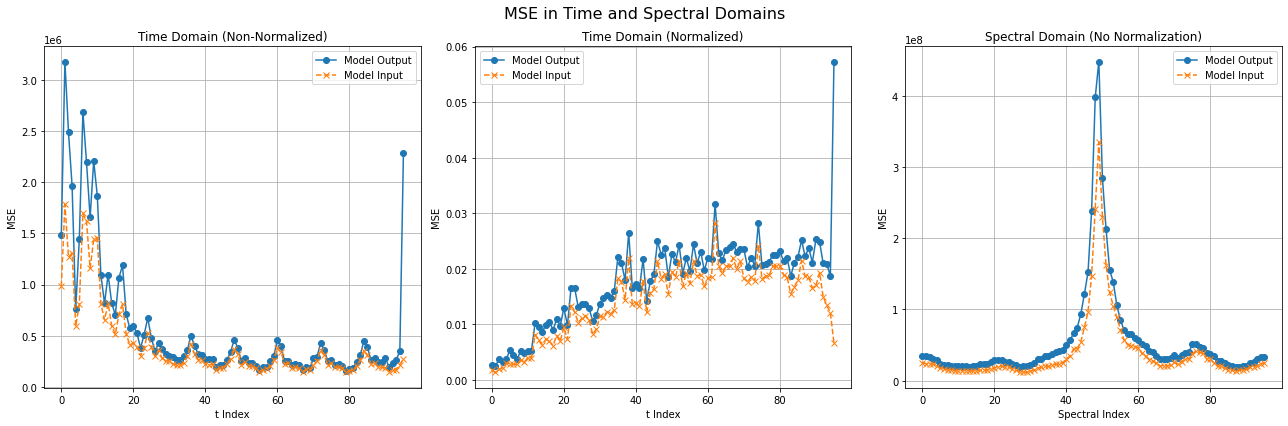

==== Model Output vs Ground Truth ====
Total MSE in image domain: 285238.33926455263
Normalized Total MSE in image domain: 0.008864583665504569
Total MSE in spectral domain: 27382880.56939705

==== Model Input vs Ground Truth ====
Total MSE in image domain: 201320.45628786398
Normalized Total MSE in image domain: 0.007091225467733716
Total MSE in spectral domain: 19326763.80363494


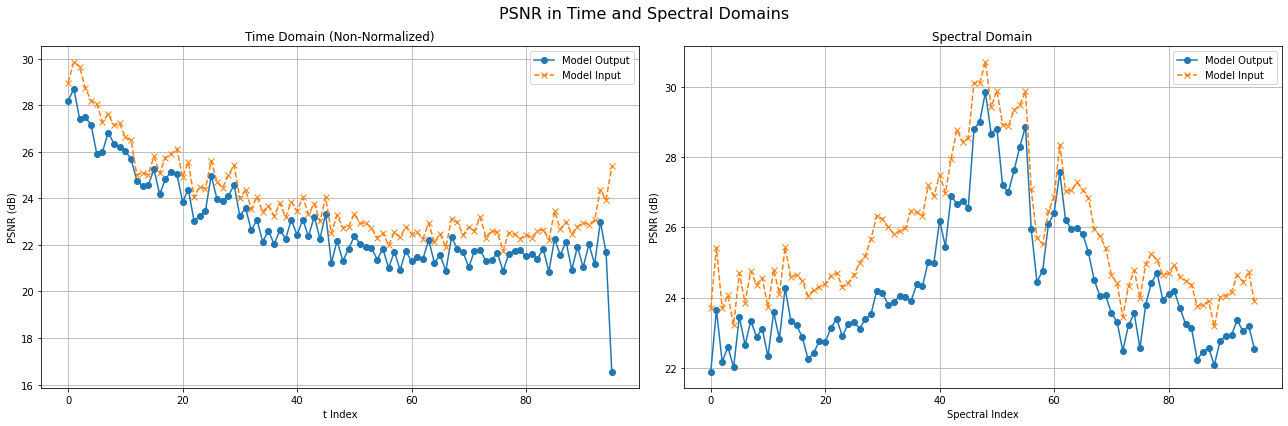

==== Model Output vs. Ground Truth ====
Average PSNR in image domain:    22.909875289514115
Average PSNR in frequency domain: 24.339751440909026

==== Model Input vs. Ground Truth ====
Average PSNR in image domain:    24.002501215583425
Average PSNR in frequency domain: 25.723713820757723


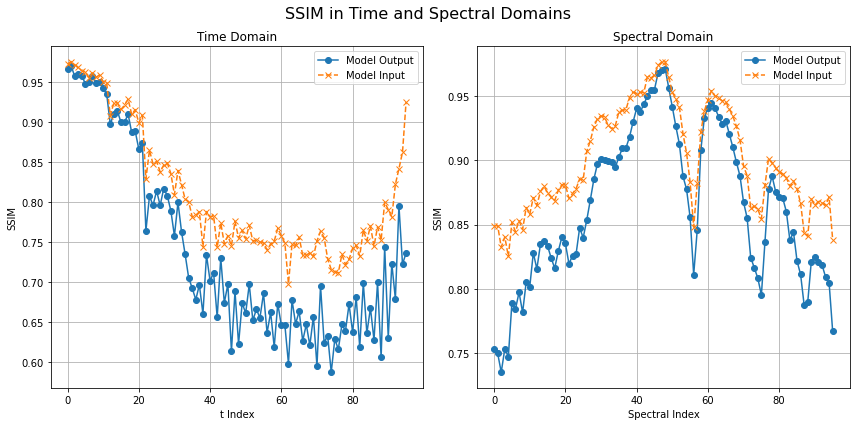

==== Model Output vs. Ground Truth ====
Average SSIM in image domain:    0.7397110125399934
Average SSIM in frequency domain: 0.8625421625913486

==== Model Input vs. Ground Truth ====
Average SSIM in image domain:    0.8110492883743466
Average SSIM in frequency domain: 0.8999768806515588


In [6]:
norm_values_test = norm_values_test.reshape(trancuate_t,8)

Model_Outputs_Test_Set, ground_truth = Process_Model_Output_deeper(test_loader, model, device, trancuate_t, 8, grouped_time_steps, norm_values_test)

ground_truth = Ground_Truth[:,:,:,:trancuate_t,:,Test_Set]

mask = np.load('../data/masks.npy')
mask_5 = mask[:,:,:,Test_Set]
mask_5D = mask_5[:,:,:, np.newaxis, np.newaxis]

model_input = low_rank(Undersampled_Data[...,0], 8)*mask_5D
model_input = model_input[:,:,:,:trancuate_t,:]

ground_truth = ground_truth*mask_5D
Model_Outputs_Test_Set = Model_Outputs_Test_Set*mask_5D ### I mask for both IFFT and model output to be fair

plot_general_statistics(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")
plot_general_statistics_PSNR(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")
plot_general_statistics_SSIM(Model_Outputs_Test_Set, model_input, ground_truth, trancuate_t, norm_values_test, label = "Model Output", label2 = "Model Input")

/opt/conda/lib/python3.7/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)
../scripts/output_statistics.py:282: RuntimeWarning: invalid value encountered in double_scalars
  return calculate_rmse(pred, gt) / (gt.max() - gt.min())


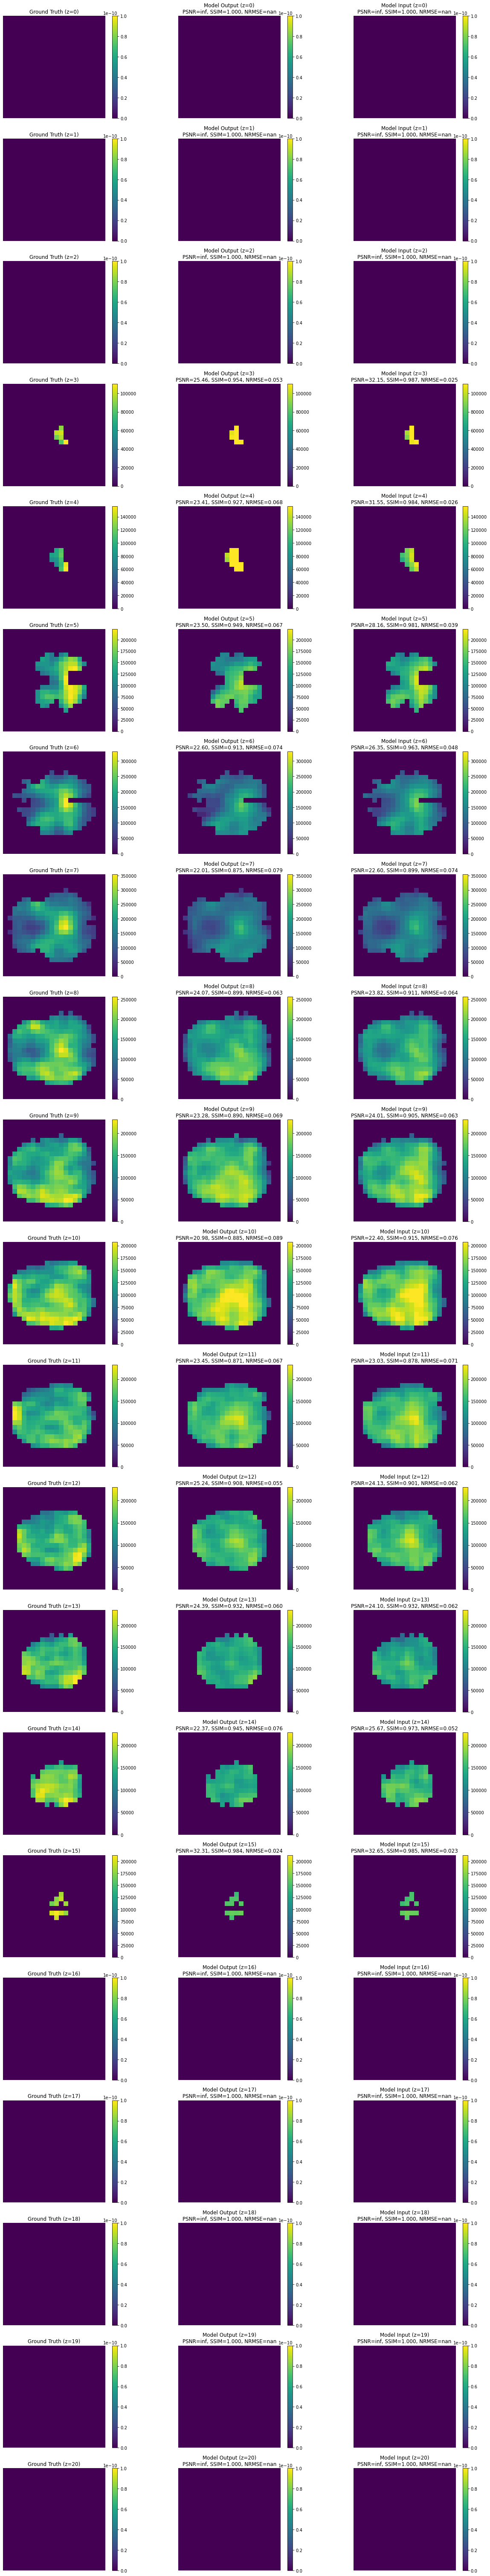

In [7]:
tf = 50 #50 = Water, 60 Glucose, 24 Glx
T = 0
comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set, ground_truth, model_input, tf, T, domain="spectral", label = "Model Output", label2 = "Model Input")

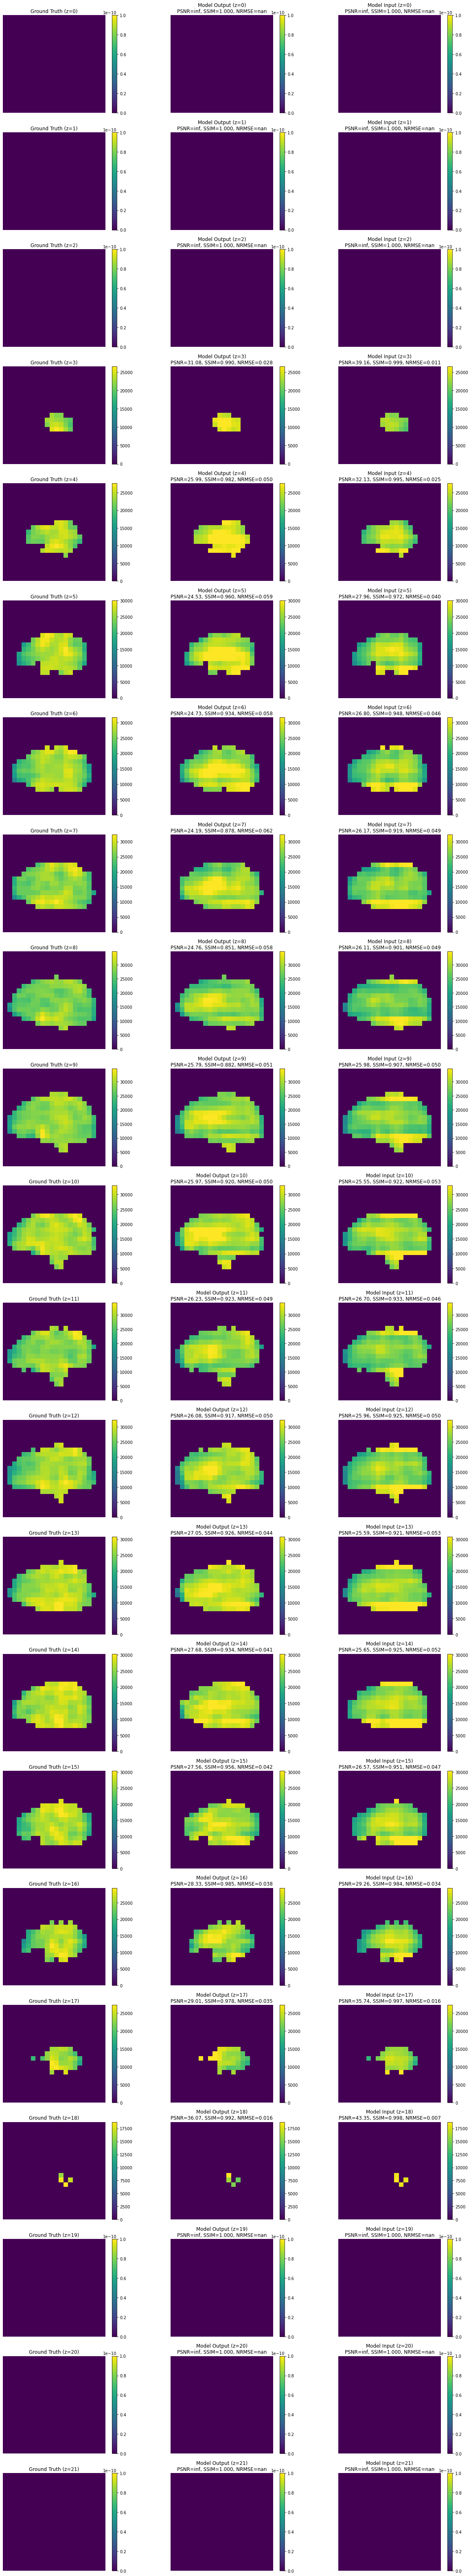

In [8]:
tf = 1 #50 = Water, 60 Glucose, 24 Glx
T = 7

### NOTE: The labels are off, due to swapping I actually show z-y images along the x axis
ground_truth_swapped = np.swapaxes(ground_truth, 0, 2)
Model_Outputs_Test_Set_swapped = np.swapaxes(Model_Outputs_Test_Set, 0, 2)
model_input_swapped = np.swapaxes(model_input, 0, 2)

comparison_Plot_3D_vs_Ifft(Model_Outputs_Test_Set_swapped, ground_truth_swapped, model_input_swapped, tf, T, domain="time", label = "Model Output", label2 = "Model Input")

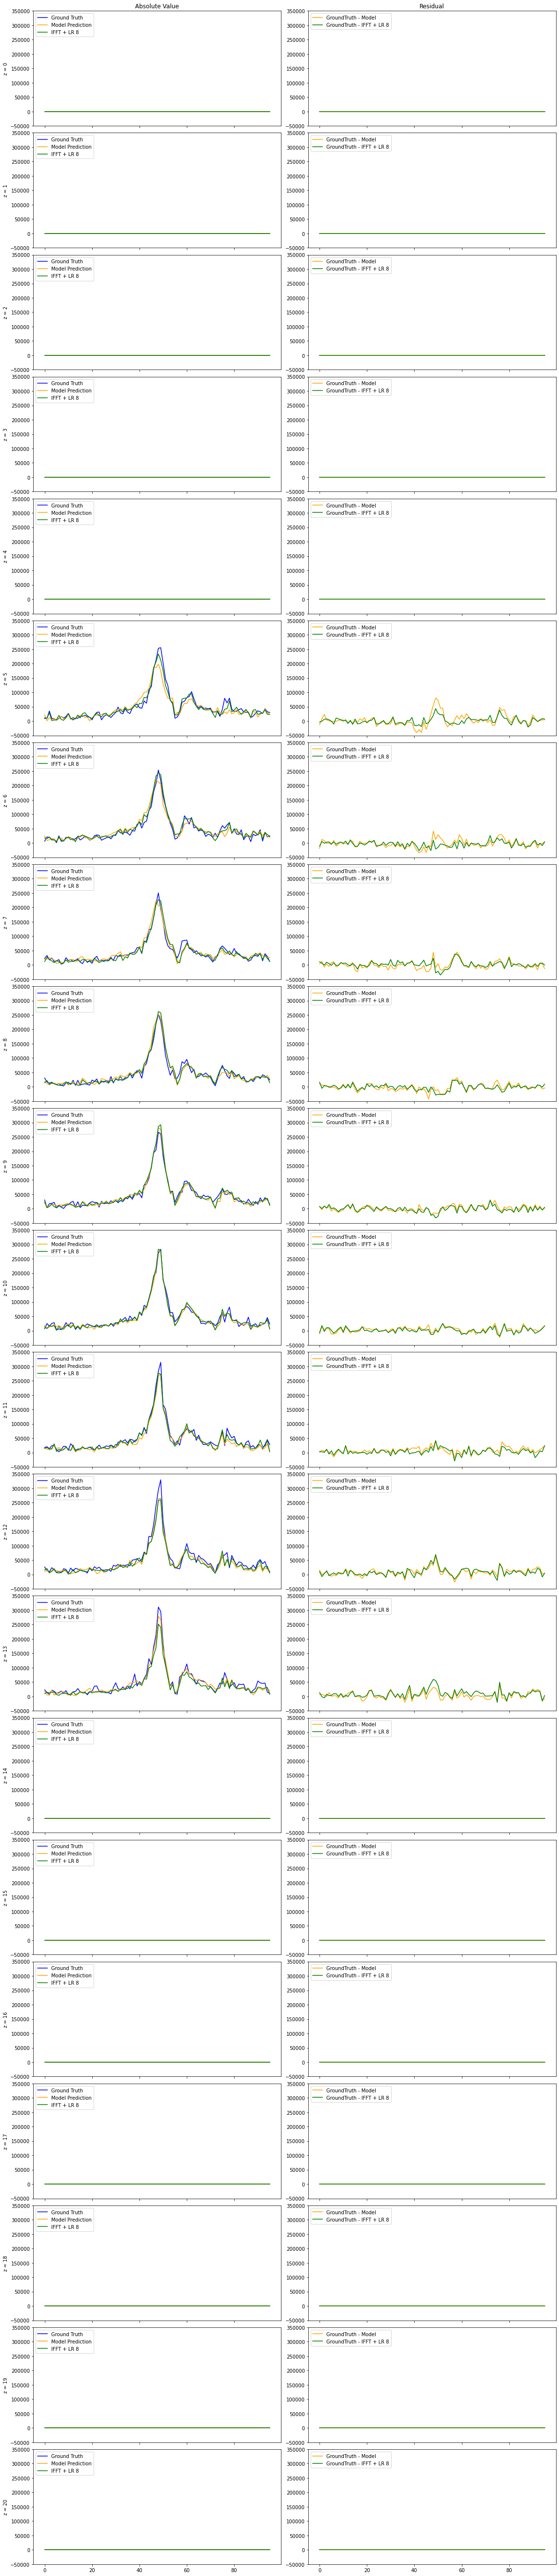

In [9]:
ground_truth_spectral = np.fft.fftshift(np.fft.fft(ground_truth, axis=-2), axes=-2)
model_pred_spectral = np.fft.fftshift(np.fft.fft(Model_Outputs_Test_Set, axis=-2), axes=-2)
IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)

IFF_LR_8 = np.fft.fftshift(np.fft.fft(model_input, axis=-2), axes=-2)
# Fixed indices for x, y, and T:
# ----------------------------------------------------------------------
# Fixed indices for x, y, and T
# ----------------------------------------------------------------------
x_fixed = 15
y_fixed = 15
T_fixed = 7

num_z = 21  # Number of z slices

# ----------------------------------------------------------------------
# Create a figure with 2 columns:
#   Column 1 -> Absolute value plots
#   Column 2 -> Residuals (GT - [Others])
# ----------------------------------------------------------------------
fig, axes = plt.subplots(nrows=num_z, ncols=2, figsize=(16, num_z * 3.5), sharex=True)

# If there's only one row, ensure axes is 2D
if num_z == 1:
    axes = np.array([axes])

for z in range(num_z):
    # Extract the spectra at [x_fixed, y_fixed, z, :, T_fixed]
    gt_spec  = ground_truth_spectral[x_fixed, y_fixed, z, :, T_fixed]
    mp_spec  = model_pred_spectral[x_fixed, y_fixed, z, :, T_fixed]
    iff_spec = IFF_LR_8[x_fixed, y_fixed, z, :, T_fixed]
    
    # ------------------------------------------------------------------
    # Column 1: Plot absolute spectra
    # ------------------------------------------------------------------
    ax_abs = axes[z, 0]
    ax_abs.plot(np.abs(gt_spec),  label='Ground Truth',    color='blue')
    ax_abs.plot(np.abs(mp_spec),  label='Model Prediction',color='orange')
    ax_abs.plot(np.abs(iff_spec), label='IFFT + LR 8',     color='green')
    ax_abs.set_ylim(-50000, 350000)
    # Row label on the Y-axis
    ax_abs.set_ylabel(f'z = {z}')
    
    if z == 0:
        ax_abs.set_title('Absolute Value')
    ax_abs.legend(loc='upper left')
    
    # ------------------------------------------------------------------
    # Column 2: Plot residuals (Ground Truth - [Others])
    # ------------------------------------------------------------------
    ax_res = axes[z, 1]
    
    residual_gt_mp  = np.abs(gt_spec) - np.abs(mp_spec)
    residual_gt_iff = np.abs(gt_spec) - np.abs(iff_spec)
    
    ax_res.plot(residual_gt_mp,  label='GroundTruth - Model',        color='orange')
    ax_res.plot(residual_gt_iff, label='GroundTruth - IFFT + LR 8',  color='green')

    if z == 0:
        ax_res.set_title('Residual')
    ax_res.legend(loc='upper left')
    ax_res.set_ylim(-50000, 350000)
plt.tight_layout()
plt.show()